In [1]:
import numpy as np
import scipy.stats as si

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    S: Stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate
    sigma: Volatility
    option_type: "call" or "put"
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)

# Example Usage:
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
call_price = black_scholes(S, K, T, r, sigma, option_type="call")
print("Call Option Price:", call_price)

Call Option Price: 10.450583572185565


In [2]:
from scipy.optimize import newton

def implied_volatility(S, K, T, r, market_price, option_type="call", tol=1e-6):
    """
    Compute implied volatility using Newton-Raphson method.
    """
    def bs_diff(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price

    try:
        return newton(bs_diff, x0=0.2, tol=tol, maxiter=100)
    except RuntimeError:
        return np.nan  # Return NaN if convergence fails

# Example Usage:
market_price = 10
iv = implied_volatility(S, K, T, r, market_price, option_type="call")
print("Implied Volatility:", iv)

Implied Volatility: 0.18797164945704056


In [3]:
import pandas as pd
import numpy as np

# Generate synthetic dataset
np.random.seed(42)
data = {
    "S": np.random.uniform(80, 120, 100),
    "K": np.random.choice([90, 100, 110], 100),
    "T": np.random.uniform(0.1, 2, 100),
    "r": np.random.uniform(0.01, 0.05, 100),
    "market_price": np.random.uniform(5, 20, 100),
}

df = pd.DataFrame(data)

In [4]:
import pandas as pd

# Load Synthetic dataset 
df = pd.DataFrame(data)

# Feature Engineering
df["moneyness"] = df["S"] / df["K"]  # Moneyness ratio
df["log_moneyness"] = np.log(df["moneyness"])
df["sqrt_ttm"] = np.sqrt(df["T"])  # Time to Maturity in sqrt form
df["risk_free_rate"] = df["r"]
df["implied_volatility"] = df.apply(lambda row: implied_volatility(row["S"], row["K"], row["T"], row["r"], row["market_price"]), axis=1)

# Drop NaN values 
df = df.dropna()
df.head()


,S,K,T,r,market_price,moneyness,log_moneyness,sqrt_ttm,risk_free_rate,implied_volatility
0,94.981605,110,1.222697,0.021744,6.040420,0.863469,-0.146797,1.105756,0.021744,0.249307
4,86.240746,100,0.530342,0.046530,15.245102,0.862407,-0.148027,0.728246,0.046530,0.775504
5,86.239781,90,1.325828,0.030454,6.067830,0.958220,-0.042678,1.151446,0.030454,0.155694
6,82.323344,110,0.431296,0.030061,9.784634,0.748394,-0.289826,0.656731,0.030061,0.825502
7,114.647046,110,1.412782,0.041932,17.673130,1.042246,0.041378,1.188605,0.041932,0.220124


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

# Define Features & Target
X = df[["S", "K", "T", "r", "moneyness", "log_moneyness", "sqrt_ttm"]]
y = df["implied_volatility"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Network Model
def build_nn():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)  # Output: Implied Volatility
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Train Model
nn_model = build_nn()
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Train XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Compare Performance
nn_preds = nn_model.predict(X_test).flatten()
xgb_preds = xgb_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error
print("NN MSE:", mean_squared_error(y_test, nn_preds))
print("XGB MSE:", mean_squared_error(y_test, xgb_preds))

Epoch 1/50
2/2 [==============================] - 0s 66ms/step - loss: 0.5387 - val_loss: 0.1908
Epoch 2/50
2/2 [==============================] - 0s 11ms/step - loss: 0.3807 - val_loss: 0.1230
Epoch 3/50
2/2 [==============================] - 0s 11ms/step - loss: 0.2632 - val_loss: 0.0751
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1780 - val_loss: 0.0456
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1260 - val_loss: 0.0315
Epoch 6/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0944 - val_loss: 0.0281
Epoch 7/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0800 - val_loss: 0.0311
Epoch 8/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0744 - val_loss: 0.0374
Epoch 9/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0706 - val_loss: 0.0439
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0672 - val_loss: 0.0481
Epoch 11/50
2/2 [============

In [6]:
# --------------------------------------------
# Hybrid Model: Averaging NN and XGB predictions
# --------------------------------------------

# Simple average (equal weighting)
hybrid_preds = (nn_preds + xgb_preds) / 2

# Evaluate Hybrid
hybrid_mse = mean_squared_error(y_test, hybrid_preds)
print("Hybrid MSE (Avg):", hybrid_mse)

# Optional: Weighted average (you can tune weights based on performance)
weight_nn = 0.4
weight_xgb = 0.6
hybrid_weighted_preds = (weight_nn * nn_preds) + (weight_xgb * xgb_preds)
weighted_hybrid_mse = mean_squared_error(y_test, hybrid_weighted_preds)
print(f"Hybrid MSE (Weighted {weight_nn}/{weight_xgb}):", weighted_hybrid_mse)

Hybrid MSE (Avg): 0.06710841751278301
Hybrid MSE (Weighted 0.4/0.6): 0.07089012870353104


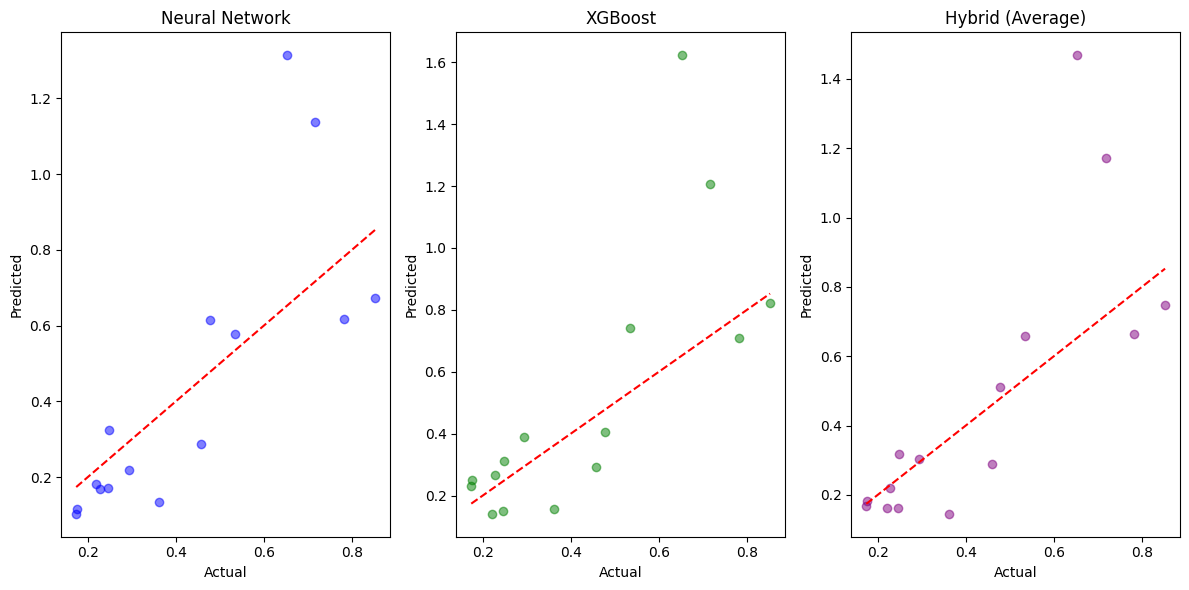

In [7]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted
plt.figure(figsize=(12, 6))

# NN Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_test, nn_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.title("Neural Network")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# XGBoost Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("XGBoost")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Hybrid Predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test, hybrid_preds, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Hybrid (Average)")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

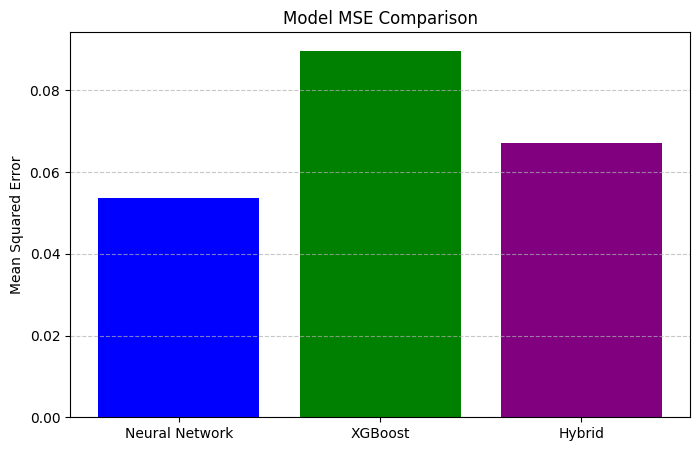

In [8]:
# Bar plot to compare MSEs
mse_values = [
    mean_squared_error(y_test, nn_preds),
    mean_squared_error(y_test, xgb_preds),
    mean_squared_error(y_test, hybrid_preds)
]
model_names = ['Neural Network', 'XGBoost', 'Hybrid']

plt.figure(figsize=(8, 5))
plt.bar(model_names, mse_values, color=['blue', 'green', 'purple'])
plt.title("Model MSE Comparison")
plt.ylabel("Mean Squared Error")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np

# Define Features & Target
X = df[["S", "K", "T", "r", "moneyness", "log_moneyness", "sqrt_ttm"]]
y = df["implied_volatility"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------------------- OPTUNA TUNING FOR NN -----------------------
# Outside objective() – this is the reusable prediction function
def predict_model(model, X):
    return model.predict(X, verbose=0).flatten()

# Objective function
def objective(trial):
    n_units1 = trial.suggest_int("n_units1", 16, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = keras.Sequential([
        layers.Dense(n_units1, activation="relu"),
        layers.Dense(n_units2, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=lr), loss="mse")
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    preds = predict_model(model, X_test)
    return mean_squared_error(y_test, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Use the best parameters to train final NN
best_params = study.best_params
nn_model = keras.Sequential([
    layers.Dense(best_params["n_units1"], activation="relu"),
    layers.Dense(best_params["n_units2"], activation="relu"),
    layers.Dense(1)
])
nn_model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=best_params["lr"]), loss="mse")
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions from Optimized NN
nn_preds = nn_model.predict(X_test).flatten()

# ---------------------- XGBOOST MODEL -----------------------
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, learning_rate=0.05)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# ---------------------- HYBRID MODEL -----------------------
hybrid_preds = (nn_preds + xgb_preds) / 2

# ---------------------- EVALUATION -----------------------
print("Optimized NN MSE:", mean_squared_error(y_test, nn_preds))
print("XGBoost MSE:", mean_squared_error(y_test, xgb_preds))
print("Hybrid Model MSE:", mean_squared_error(y_test, hybrid_preds))


[I 2025-04-28 09:37:14,430] A new study created in memory with name: no-name-243c07f2-ccbf-42f9-bedf-0308634a30ba
[I 2025-04-28 09:37:14,656] Trial 0 finished with value: 0.0697021107357523 and parameters: {'n_units1': 52, 'n_units2': 87, 'lr': 0.006606551242805014}. Best is trial 0 with value: 0.0697021107357523.
[I 2025-04-28 09:37:14,880] Trial 1 finished with value: 0.04171699478088498 and parameters: {'n_units1': 113, 'n_units2': 45, 'lr': 0.0001355053607581484}. Best is trial 1 with value: 0.04171699478088498.
[I 2025-04-28 09:37:15,100] Trial 2 finished with value: 0.047915958574505924 and parameters: {'n_units1': 109, 'n_units2': 91, 'lr': 0.0010571241594494122}. Best is trial 1 with value: 0.04171699478088498.


[I 2025-04-28 09:37:15,322] Trial 3 finished with value: 0.10296338687600645 and parameters: {'n_units1': 26, 'n_units2': 47, 'lr': 0.00018526075751840198}. Best is trial 1 with value: 0.04171699478088498.


[I 2025-04-28 09:37:15,546] Trial 4 finished with value: 0.02624114274752453 and parameters: {'n_units1': 71, 'n_units2': 92, 'lr': 0.00031434753409179323}. Best is trial 4 with value: 0.02624114274752453.
[I 2025-04-28 09:37:15,771] Trial 5 finished with value: 0.05756267022736788 and parameters: {'n_units1': 71, 'n_units2': 107, 'lr': 0.00483049443791979}. Best is trial 4 with value: 0.02624114274752453.
[I 2025-04-28 09:37:15,993] Trial 6 finished with value: 0.047876825240443656 and parameters: {'n_units1': 116, 'n_units2': 83, 'lr': 0.00010499504716393733}. Best is trial 4 with value: 0.02624114274752453.
[I 2025-04-28 09:37:16,212] Trial 7 finished with value: 0.04728041370866501 and parameters: {'n_units1': 84, 'n_units2': 77, 'lr': 0.00024380167662000395}. Best is trial 4 with value: 0.02624114274752453.
[I 2025-04-28 09:37:16,430] Trial 8 finished with value: 0.037606807939258816 and parameters: {'n_units1': 44, 'n_units2': 103, 'lr': 0.0002467332999545707}. Best is trial 4 wi

Epoch 1/50
2/2 [==============================] - 0s 160ms/step - loss: 0.3712 - val_loss: 0.1993
Epoch 2/50
2/2 [==============================] - 0s 12ms/step - loss: 0.3012 - val_loss: 0.1557
Epoch 3/50
2/2 [==============================] - 0s 13ms/step - loss: 0.2487 - val_loss: 0.1192
Epoch 4/50
2/2 [==============================] - 0s 13ms/step - loss: 0.2012 - val_loss: 0.0903
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1606 - val_loss: 0.0684
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1295 - val_loss: 0.0527
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1053 - val_loss: 0.0426
Epoch 8/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0866 - val_loss: 0.0371
Epoch 9/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0737 - val_loss: 0.0351
Epoch 10/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0655 - val_loss: 0.0358
Epoch 11/50
2/2 [===========